In [1]:
#Load modules
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from importlib import reload
from rbvfit import guess_profile_parameters_interactive as g
from linetools.spectra.xspectrum1d import XSpectrum1D  
import vfit_mcmc_up as mc
from rbvfit import model as m
from GUIs import rb_spec as r 
reload(m)

from pkg_resources import resource_filename
import pickle
from IGM import rb_setline as setline
from astropy.convolution import Gaussian1DKernel, convolve, Box1DKernel
from astropy.io import ascii, fits
from astropy import convolution
import os
import scipy.stats as stats

import voigt_module as voigt

In [2]:

from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MaxNLocator

rc ('xtick',labelsize=13)
rc ('ytick',labelsize=13)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (10,7)

In [3]:
c=3.e5
BIC=0

In [4]:
data_dir='/Users/ahamanowicz/Dropbox/COS-SAGA/Targets/'

tar_name='J0959+3203'
lambda_rest = [1215.67]

file=data_dir+tar_name+"/DATA/"+tar_name+"_rawbin.fits"
hdul = fits.open(file)
data=hdul[1].data

#wav=np.append(data['WAVELENGTH'][1], data['WAVELENGTH'][0])
#wav=np.append(data['WAVE'][1], data['WAVE'][0])
wav = data['WAVE']
fx = data['FLUX']
err = data['ERROR']
#fx=np.append(data['FLUX'][1], data['FLUX'][0])
#err = np.append(data['ERROR'][1], data['ERROR'][0])

#Change this to the continuum normalized spectrum you are using for the fit
sp=XSpectrum1D.from_file(data_dir+tar_name+"/DATA/"+tar_name+"_rawbin.fits")
filename=data_dir+tar_name+"/DATA/"+tar_name+"_rawbin.fits"
spec=r.read_spec(filename,filetype='xfits')
#Redshift of the absorber you are trying to fit
zabs=0.00486
#shift spec to abs restframe
wav_abs = wav/(1+zabs)
BIC=0

<IPython.core.display.Javascript object>


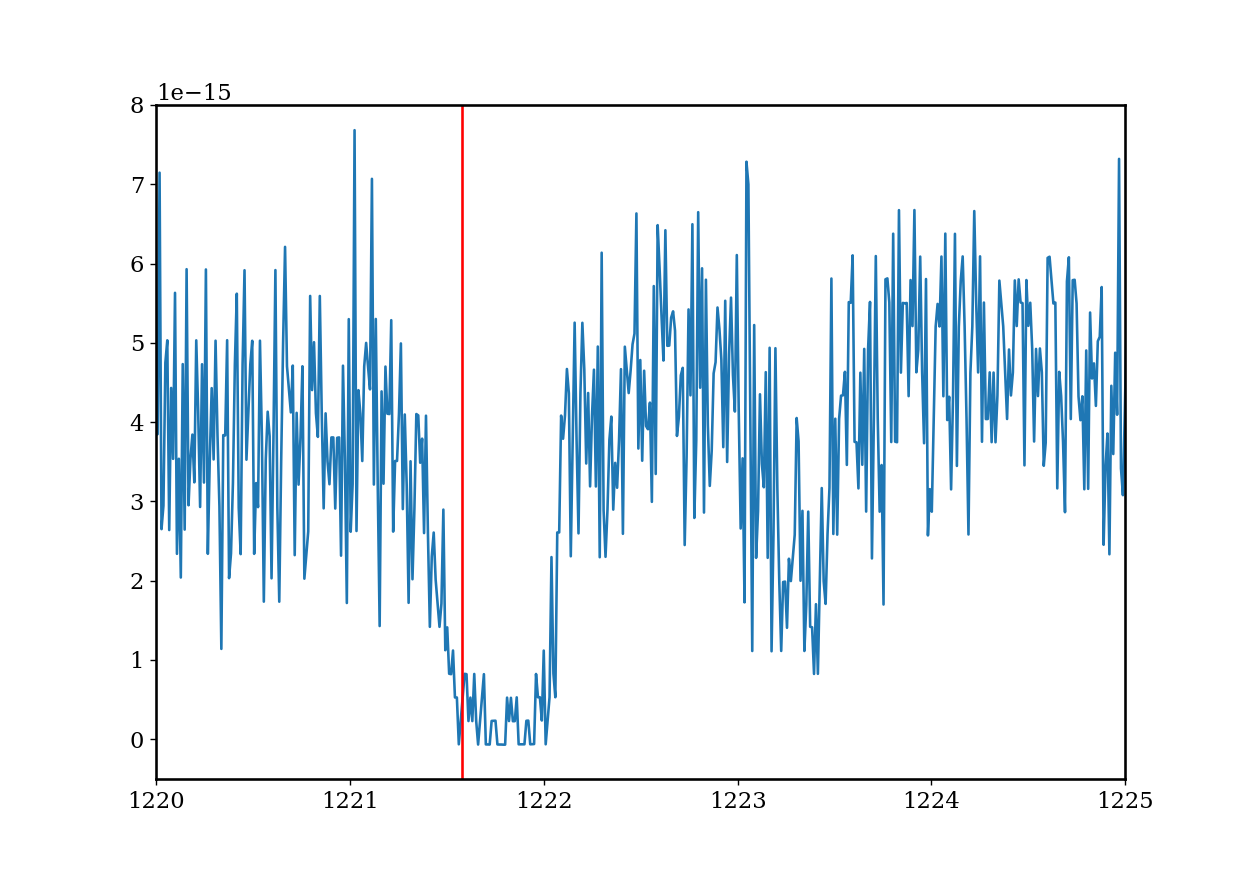

In [6]:
plt.plot(wav,fx)
#plt.plot(wav, err)

plt.ylim([-.5e-15, 8e-15])
plt.xlim([1220, 1225])
plt.axvline(lambda_rest[0]*(1+zabs), c='red')

<IPython.core.display.Javascript object>


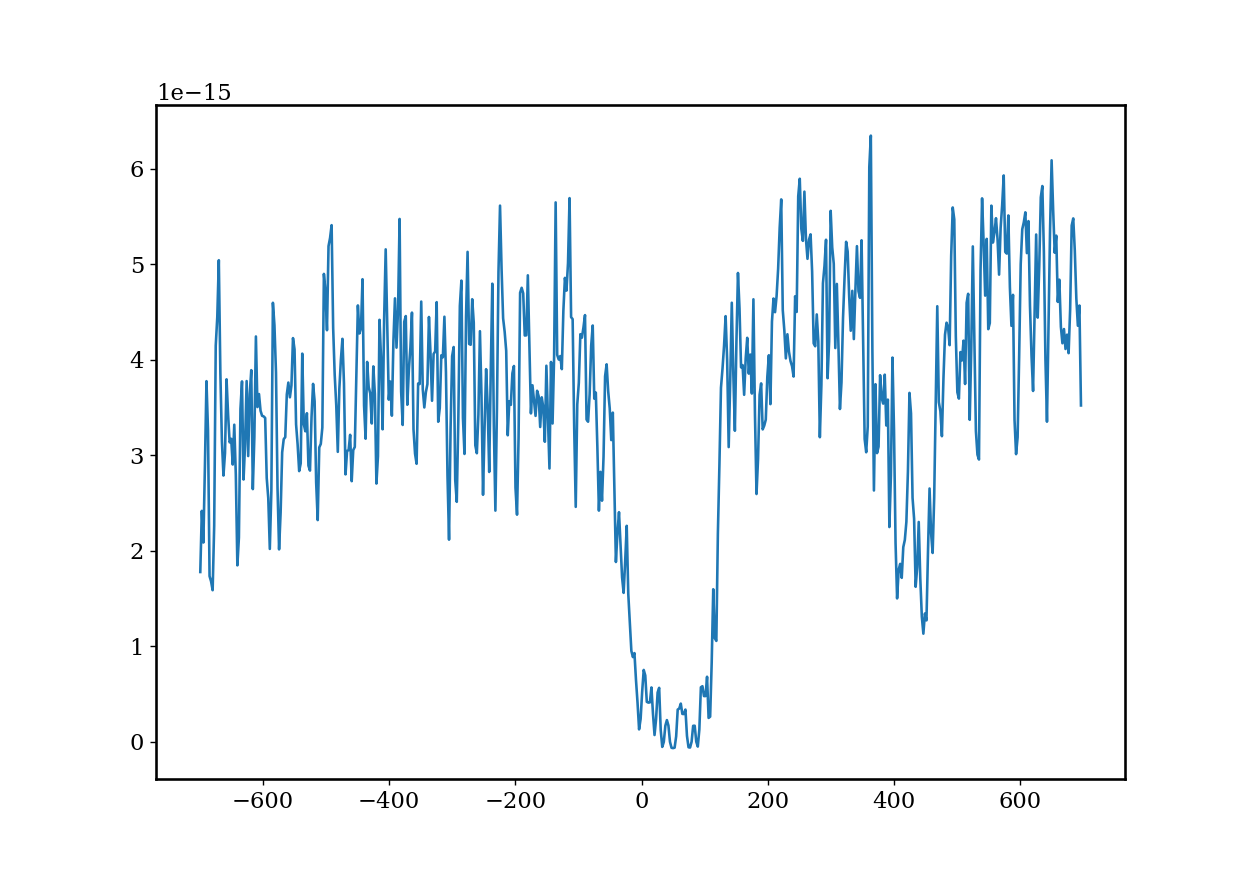

In [7]:

## wavelength slice around the desired line
transition=lambda_rest[0] #line

slice_vel, slice_flux, slice_wav=voigt.cut_spec_window(wav_abs, fx,line=transition, velcut=700 )
slice_vel_err, slice_error, slice_wav_err=voigt.cut_spec_window(wav_abs, err,line=transition, velcut=700 )


# xlim=[-500,500]
# spec.slice_spec(transition,xlim[0],xlim[1],use_vel=True)
# # Showing the atomic tranistion and its line properties
# str1=setline.rb_setline(transition,'closest',linelist='LLS')
smoothing = convolution.Gaussian1DKernel(0.7)
fx_smooth = convolution.convolve(slice_flux, smoothing)
plt.plot(slice_vel, fx_smooth)


USING LEGENDRE


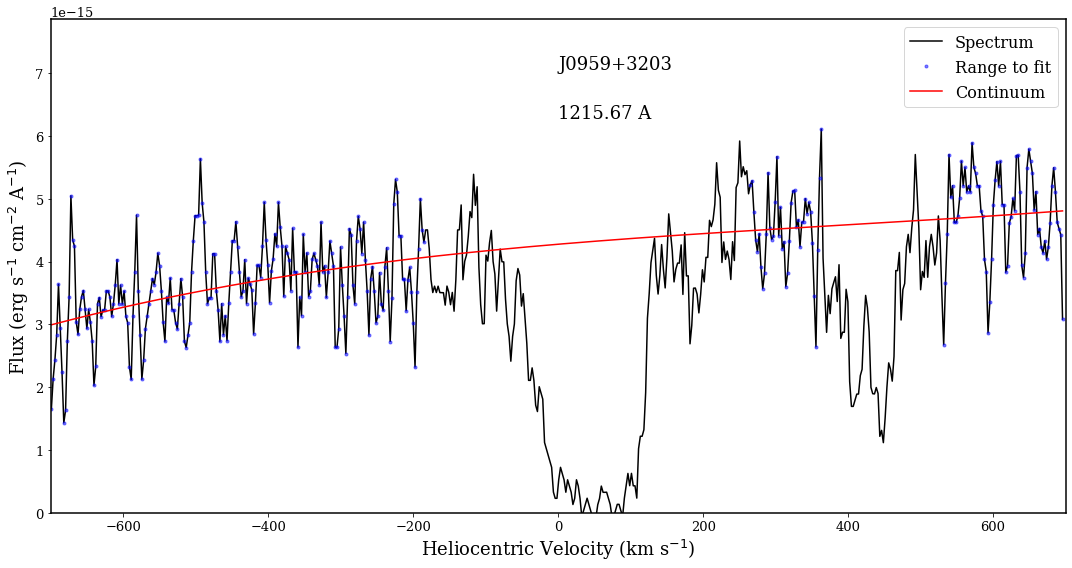

In [8]:
### continuum fitting
%matplotlib inline
rcParams['figure.figsize'] = (10,5)
window_file="cont_window_"+tar_name+".dat"
cont=voigt.cont_fit(slice_wav,slice_flux, line=transition, window_file=window_file,  degree = 3, smooth = 3, outname = tar_name+'_fitting_cont_fit', plt_vmin = -700., plt_vmax = 700., outdir = './', spline=False, show=True)


<IPython.core.display.Javascript object>


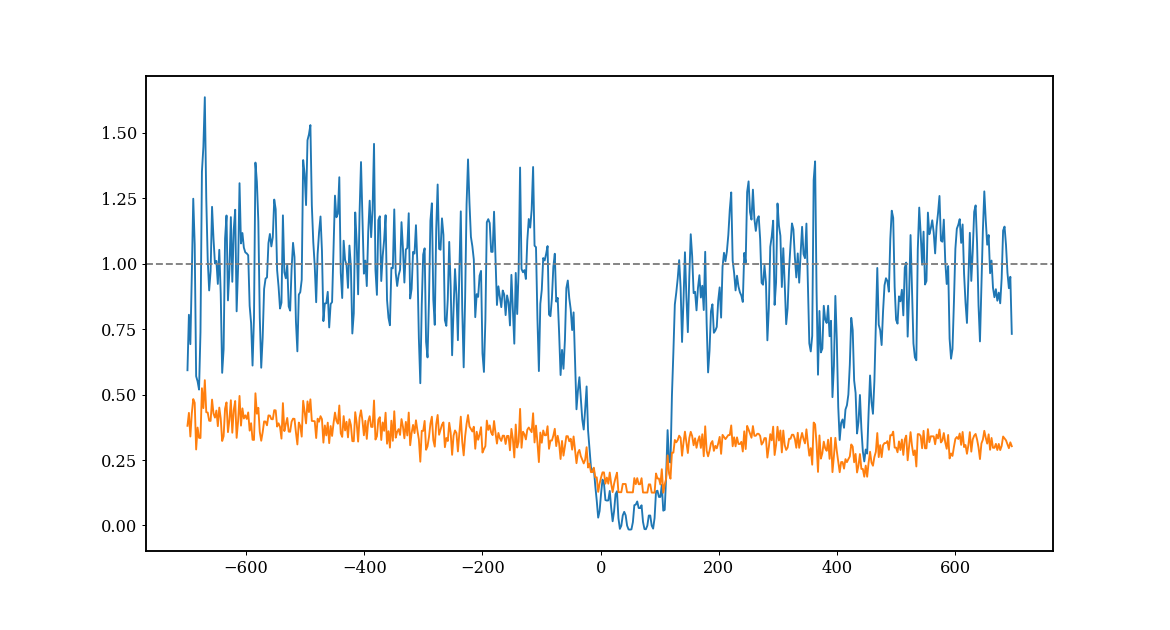

In [9]:
%matplotlib notebook
rcParams['figure.figsize'] = (13,7)
plt.plot(slice_vel, fx_smooth/cont[1])
plt.axhline(1, c='gray', ls='--')
fx_norm = slice_flux/cont[1]
fx_smooth_norm = fx_smooth/cont[1]
er_norm = slice_error/cont[1]
plt.plot(slice_vel, er_norm)

W_lambda = 0.572 +/- 0.022  \AA   over [-92.0 to 132.0]  km/s


<IPython.core.display.Javascript object>


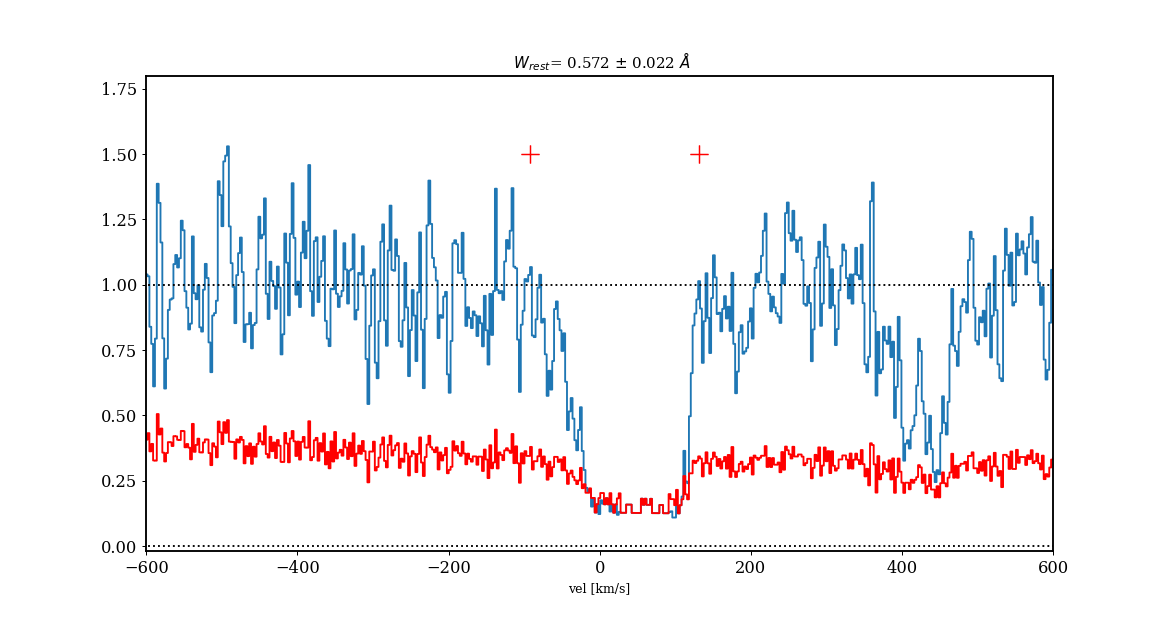

In [10]:

eqw=voigt.compute_EW(slice_wav, fx_smooth_norm, transition, lmts=[-92, 132], flx_err=er_norm,plot=True)


<IPython.core.display.Javascript object>


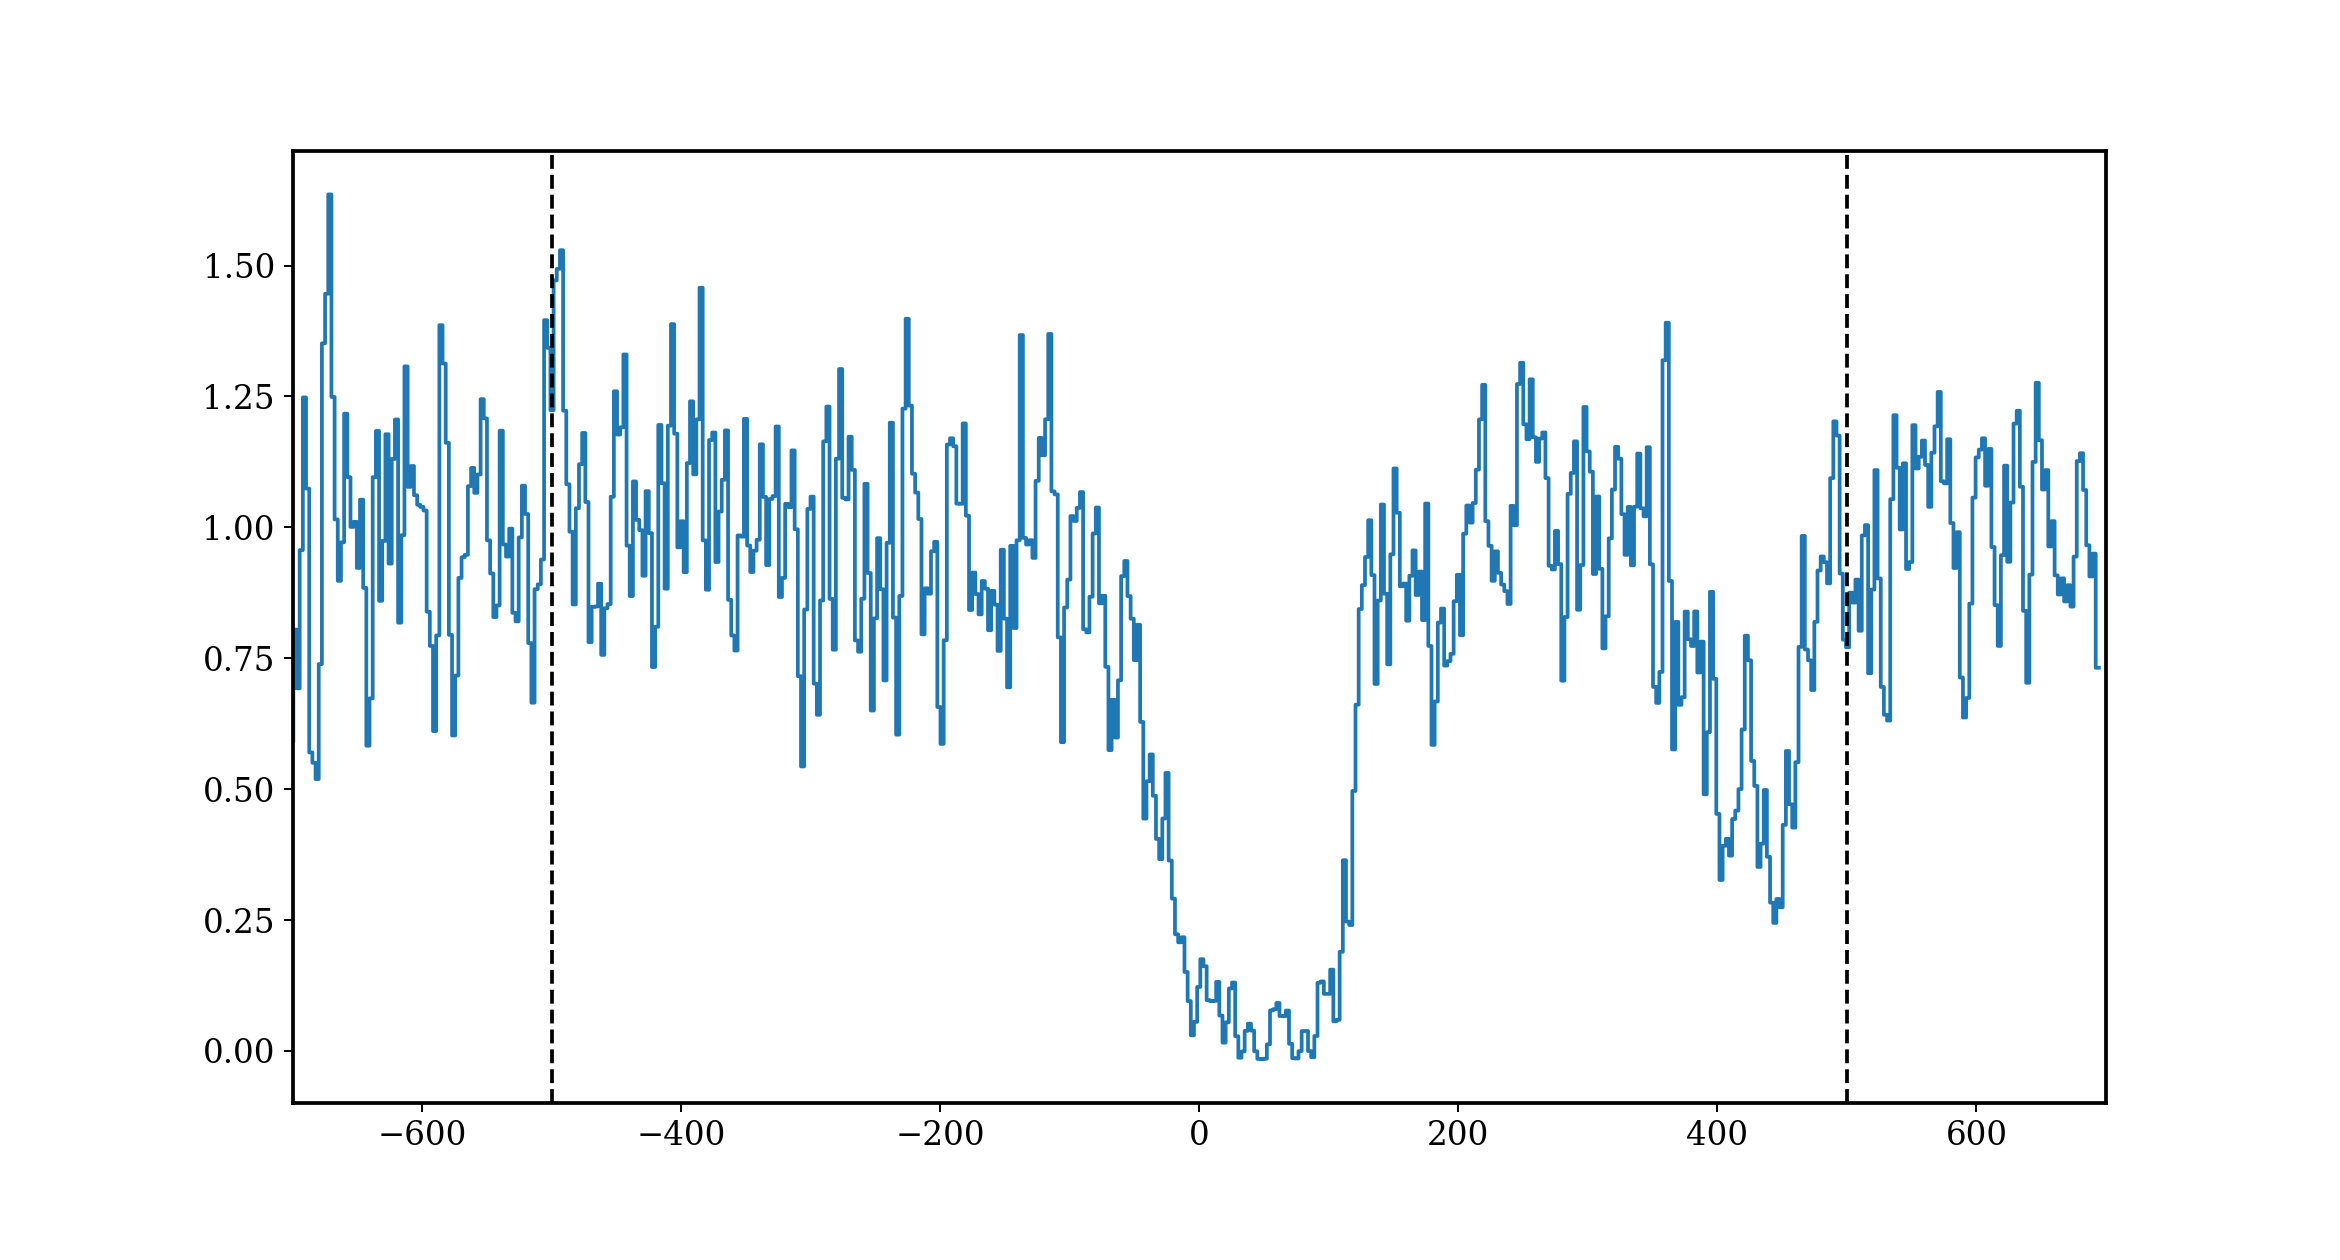

HTML(value='')

In [120]:

rcParams['figure.figsize'] = (13,7)
# search for clums
#the spectrum is already shifted to restframe so z = 0
zabs=0

#Which transitions to fit
lambda_rest = [1215.67]#,1025.6,972.5368]#,949.7431]# * np.ones((len(zabs),))


tab=g.gui_set_clump(slice_wav,fx_smooth_norm,er_norm,zabs,lambda_rest[0],xlim=[-700.,700.])
plt.axvline(-500, ls='--', c='k')
plt.axvline(500, ls='--', c='k')

# set the clumps in the spectrum. - do it by clicking on the center of the line as you think it shoudl be defined for the clump


In [135]:
#Initial guess of clouds

nguess=[13,16, 13]
bguess=[50,17, 5]
vguess=[0,60, 187] #input manually from reading from the plot

#No of clouds in the fit 
nclump= len(nguess)
#No of transitions going into the fit
ntransition=len(lambda_rest)

#Setting the upper and lower limits for the fit. You can also do it by hand if you prefer
bounds,lb,ub=mc.set_bounds(nguess,bguess,vguess)
# Doing some book keeping to organize the guess
theta=np.concatenate((nguess,bguess,vguess))

zabs=[zabs]

In [136]:
## Prepare model to fit

#------------------------------------------------------

print('Preparing model to fit **********')

wave = slice_wav
flux = fx_norm
error = er_norm


# I am using a default Gaussian FWHM of 6.5 pixels for HST/COS data, you can replace this with grating, and lifetime information to use the exact HST/COS LSF
s=m.create_voigt(zabs,lambda_rest,nclump,ntransition=ntransition,FWHM = 'COS', grating='G130M',life_position='4')
#s=m.create_voigt(zabs,lambda_rest,nclump,ntransition=ntransition,FWHM = 30.)


y=s.model_flux(theta,slice_wav)
print(' Done Preparing Model ************')

Preparing model to fit **********
Added line:HI 1215 at z:0
Added line:HI 1215 at z:0
Added line:HI 1215 at z:0
 Done Preparing Model ************


<IPython.core.display.Javascript object>


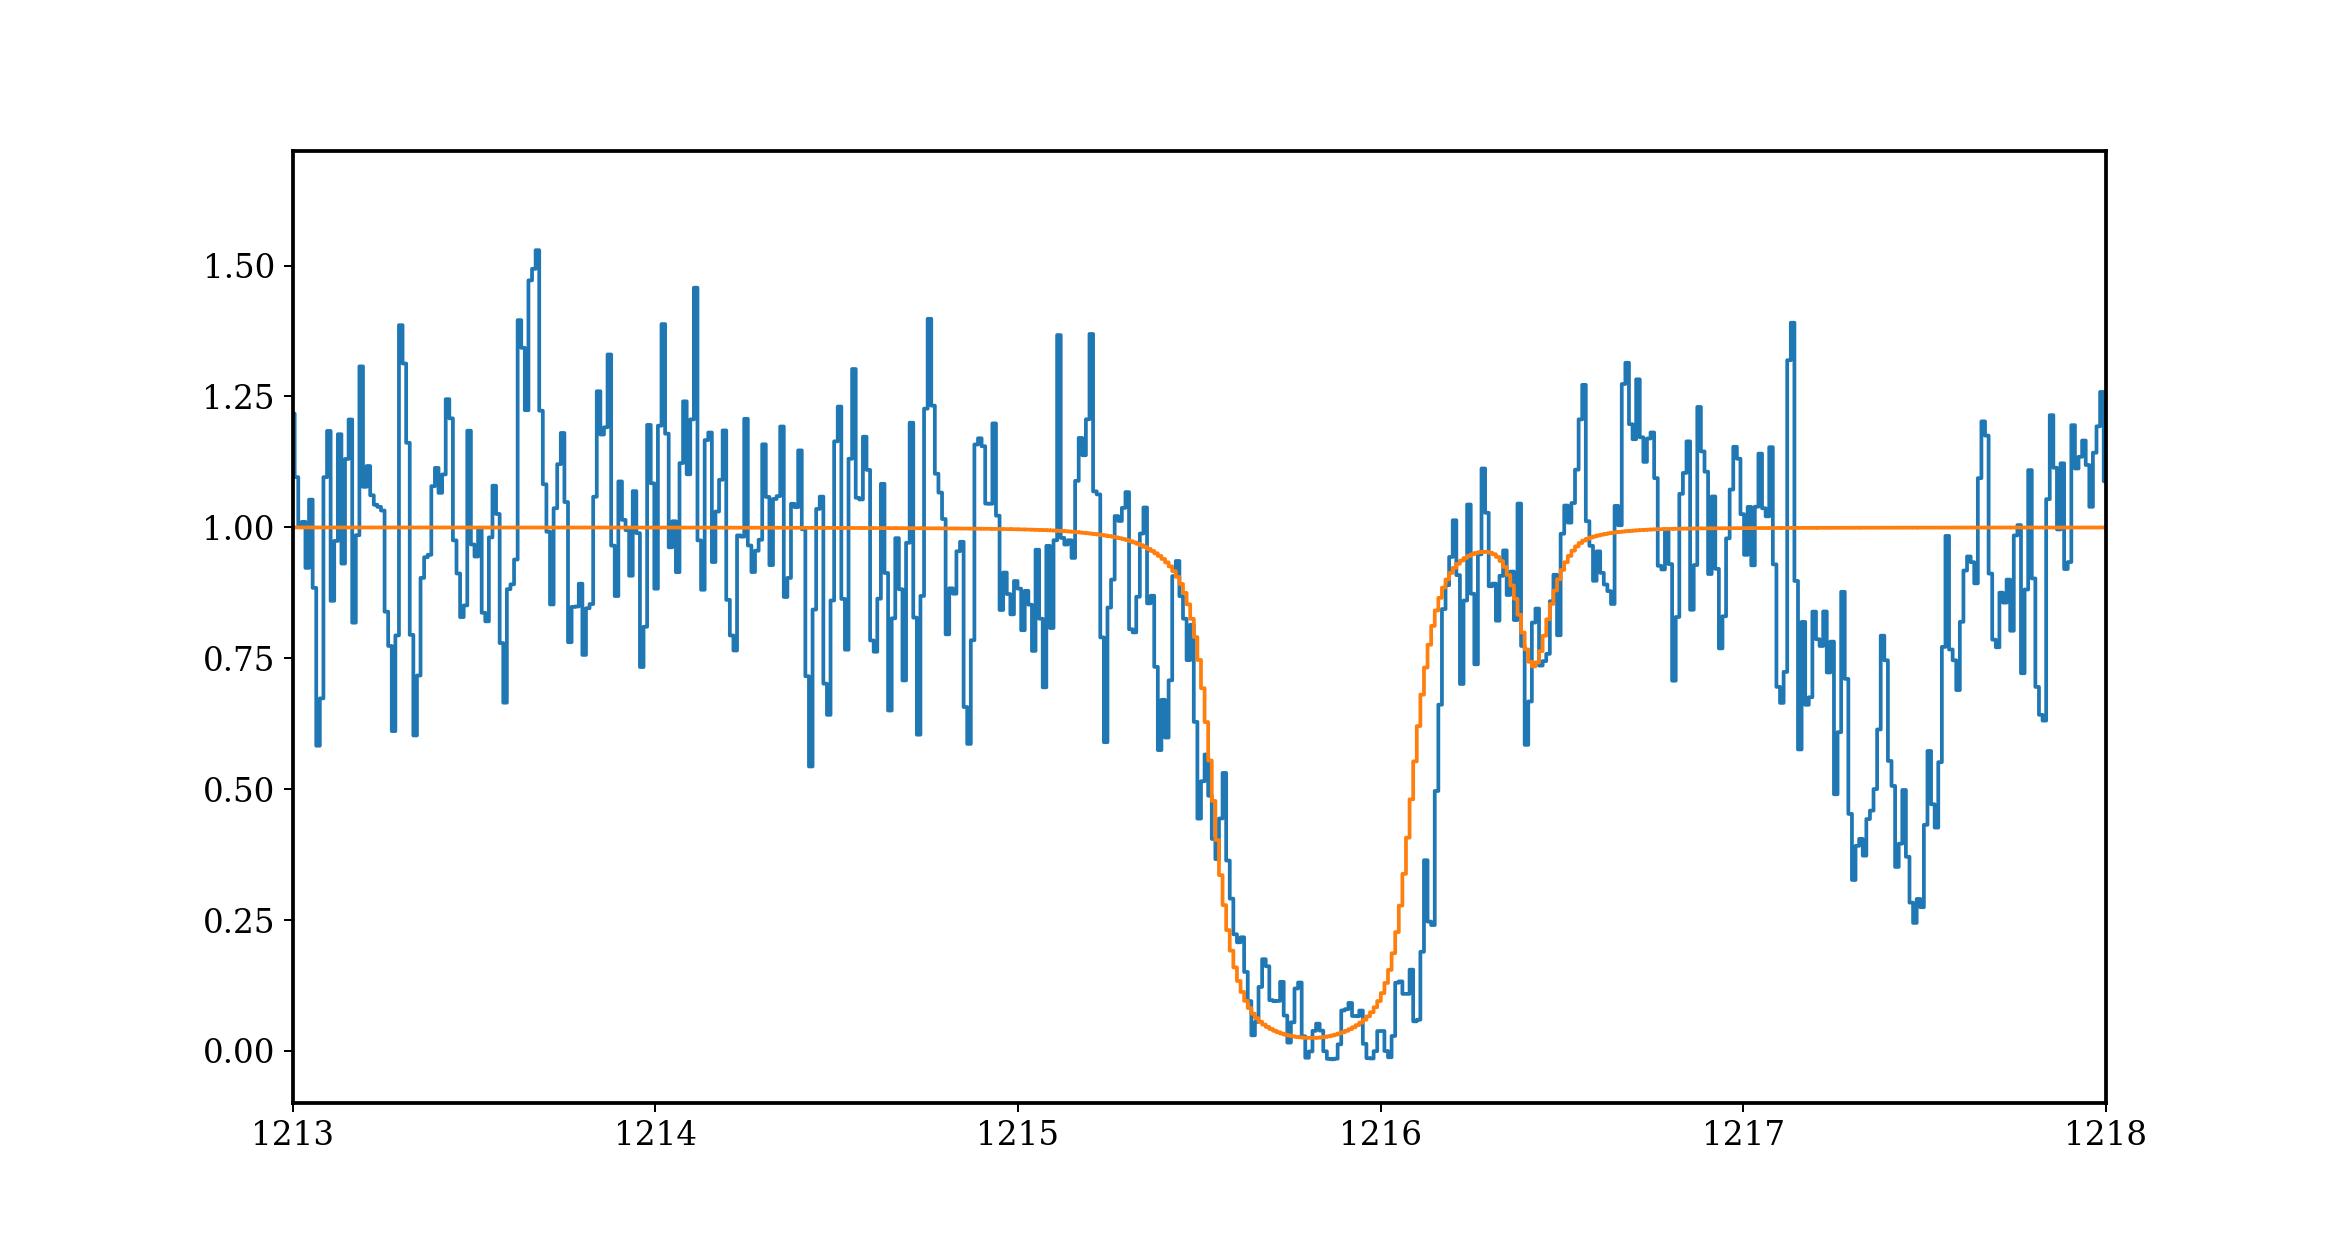

(1213.0, 1218.0)

In [137]:
plt.step(wave,fx_smooth_norm)
plt.step(wave,y)


plt.xlim([1213, 1218])


In [138]:
t = mc.vfit(s.model_flux, theta, lb, ub, slice_wav, fx_norm, er_norm, no_of_Chain=50, no_of_steps=5000)
t.runmcmc(verbose=True)

Optimizing Guess ***********
Done ***********
Preparing emcee ***********
Starting emcee ***********


/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 5000/5000 [01:01<00:00, 81.02it/s]


Done!
*****************


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [141]:
sampl = t.sampler
chains= sampl.chain
lnprob=sampl.lnprobability


In [142]:
print(np.shape(chains), np.shape(lnprob))
# chains - malkers, steps, params

(50, 5000, 9) (50, 5000)


In [143]:
### DIC
L = np.amax(lnprob)
#print L
P = 2.*(L-np.mean(lnprob))
#print P
DIC = np.array([-2.*(L-P)])
print("maxln:", L)

maxln: 389.5465403243716


<IPython.core.display.Javascript object>


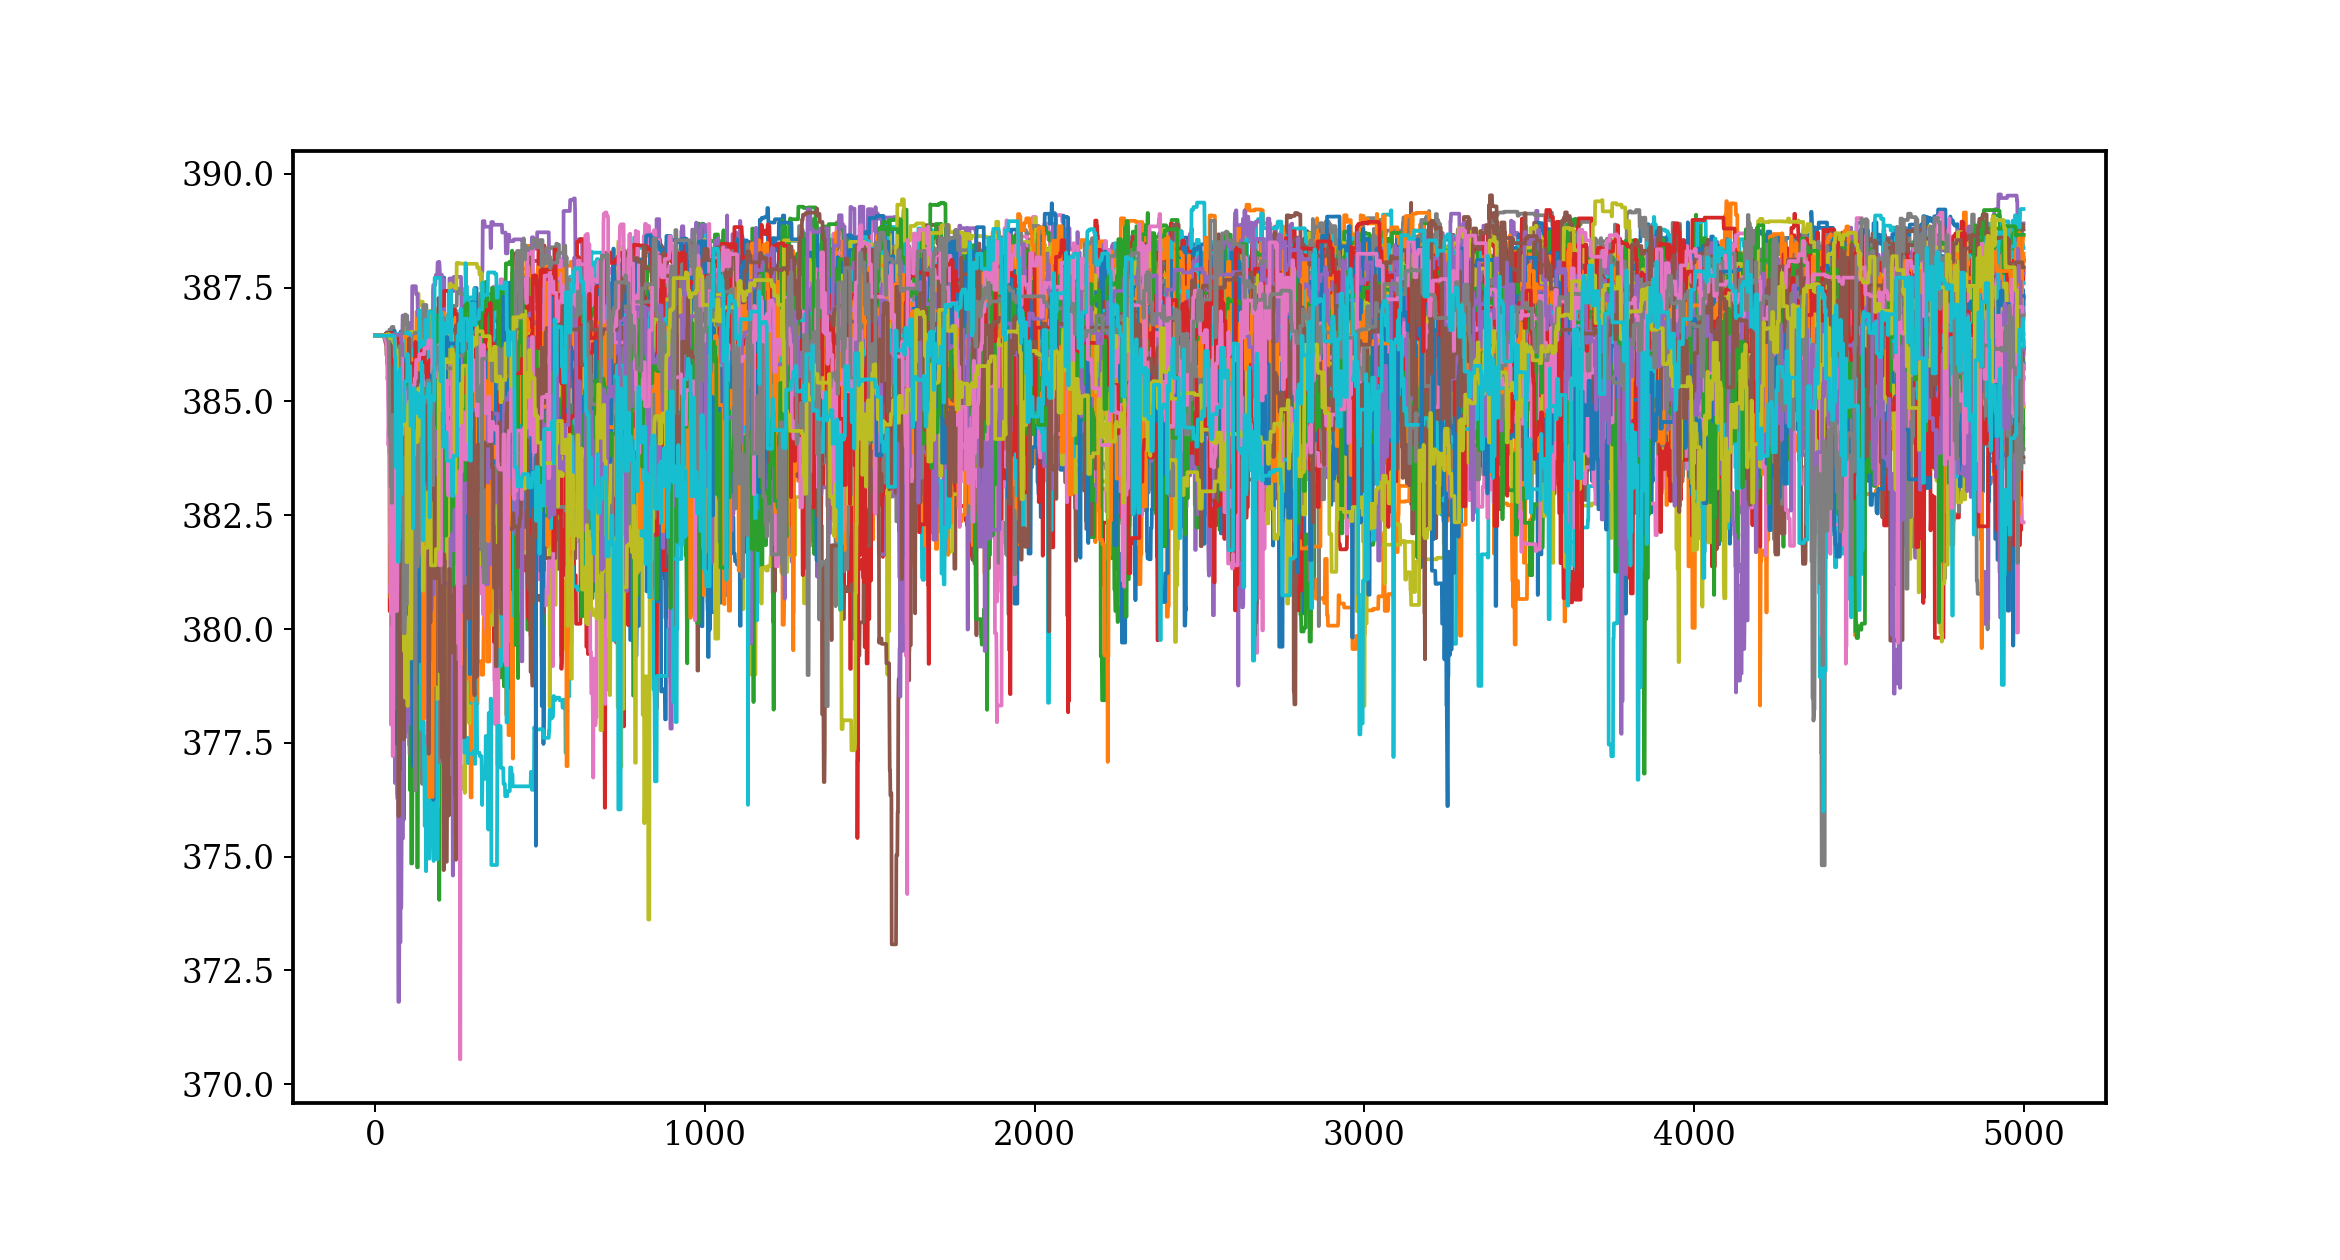

In [144]:
fig=plt.figure(figsize=(13,7))
for i in range(0,np.shape(chains)[0]): plt.plot(lnprob[i,:])


fig.savefig("trace_plot_"+str(np.shape(chains)[1])+".pdf")

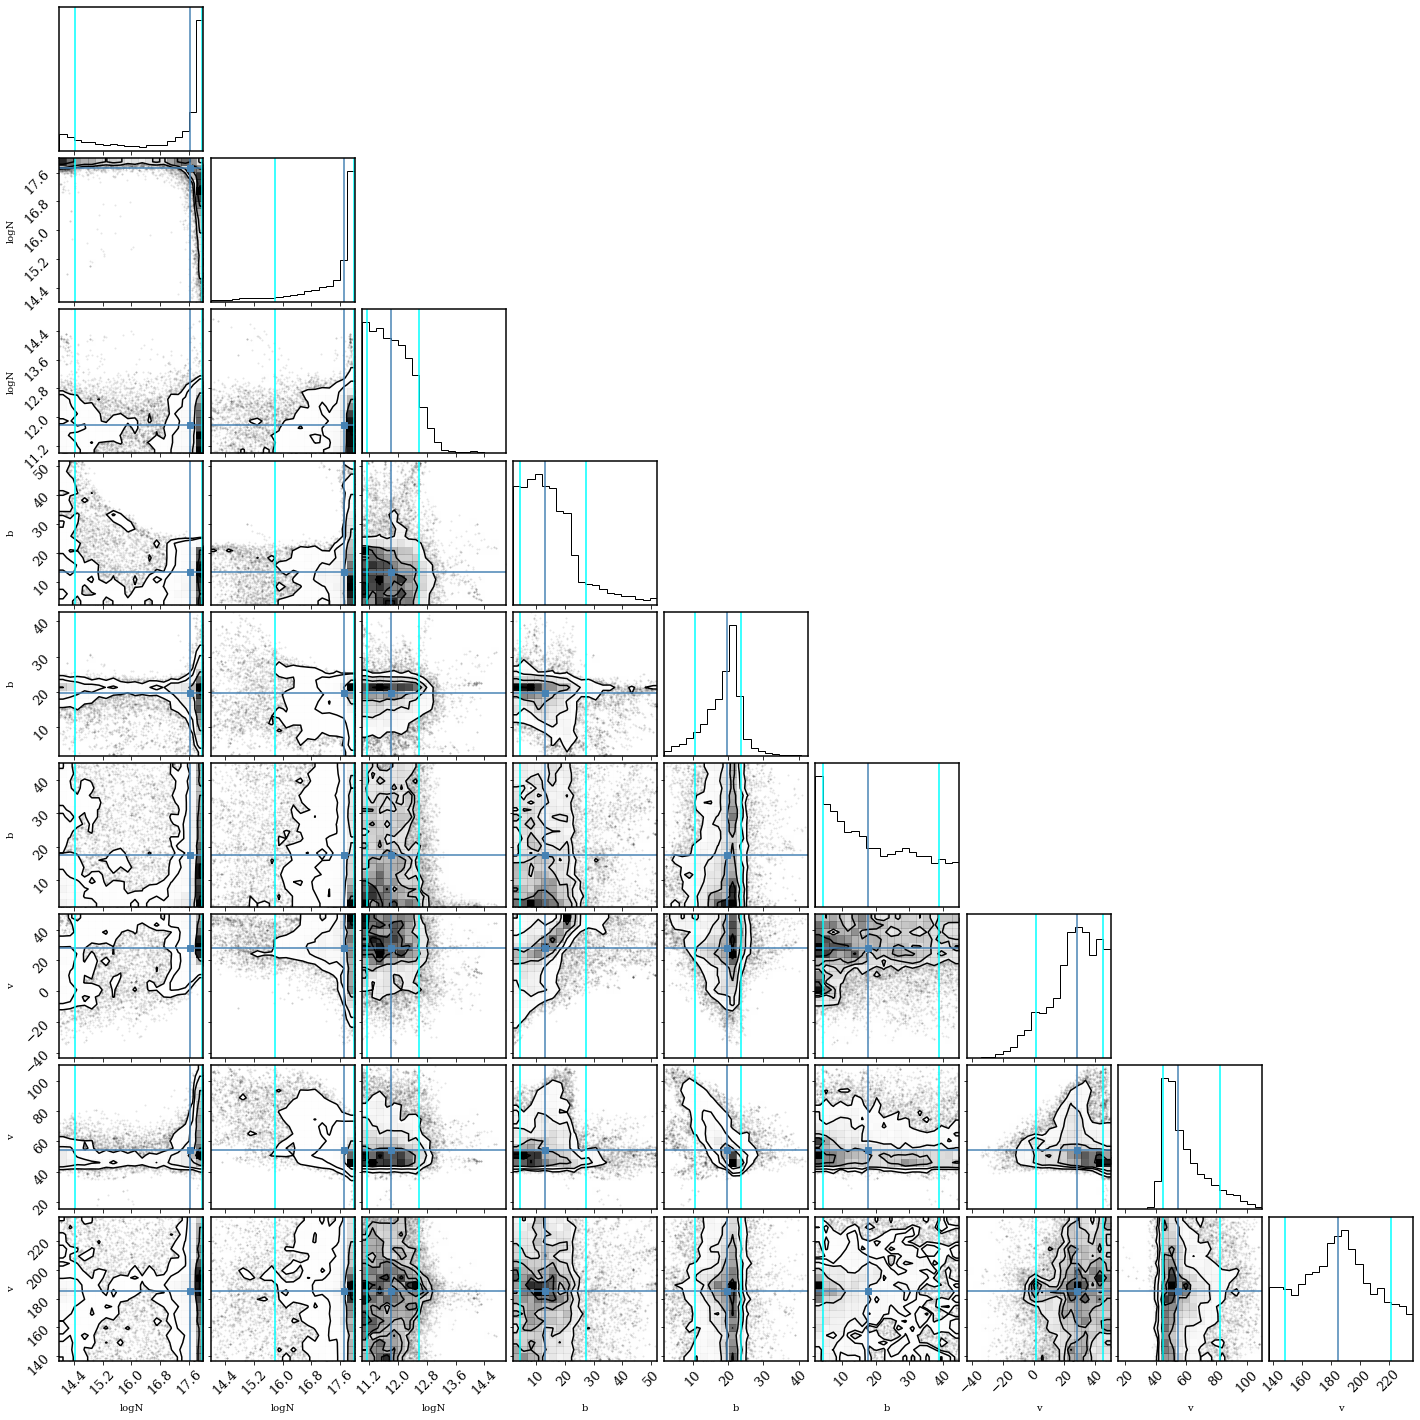

In [145]:
%matplotlib inline
t.plot_corner(no_discard=100, outfile=tar_name+"_corner_"+str(nclump)+".pdf") #necessary to obtain best fit parameters

In [146]:
inmax=np.argmax(sampl.lnprobability)
print(np.shape(lnprob))
print(np.unravel_index(inmax, np.shape(sampl.lnprobability)))

(50, 5000)
(4, 4923)


In [147]:
#extract the fit parameters
theta_prime=t.best_theta # Best Fit
theta_low=t.low_theta # lower bound
theta_high=t.high_theta # Upper bound

sample_full= t.samples  # Full Matrix containing the posterior distribution functions
print(theta_low, theta_high)


[ 14.44092914  15.8028888   11.14727323   4.33689829  10.83231178
   4.1594482    1.69859046  45.17252392 148.33745817] [ 17.96900532  17.97103657  12.59156223  27.25577068  23.535724
  38.78592717  45.32221268  82.25725015 221.48392296]


In [148]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MaxNLocator

rc ('xtick',labelsize=13)
rc ('ytick',labelsize=13)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (13,7)

In [149]:
theta_prime=t.best_theta
print(theta_prime)

[ 17.62986657  17.71748956  11.79619574  13.20655325  19.65257486
  17.66080136  28.11019913  54.460393   185.13402108]


<IPython.core.display.Javascript object>


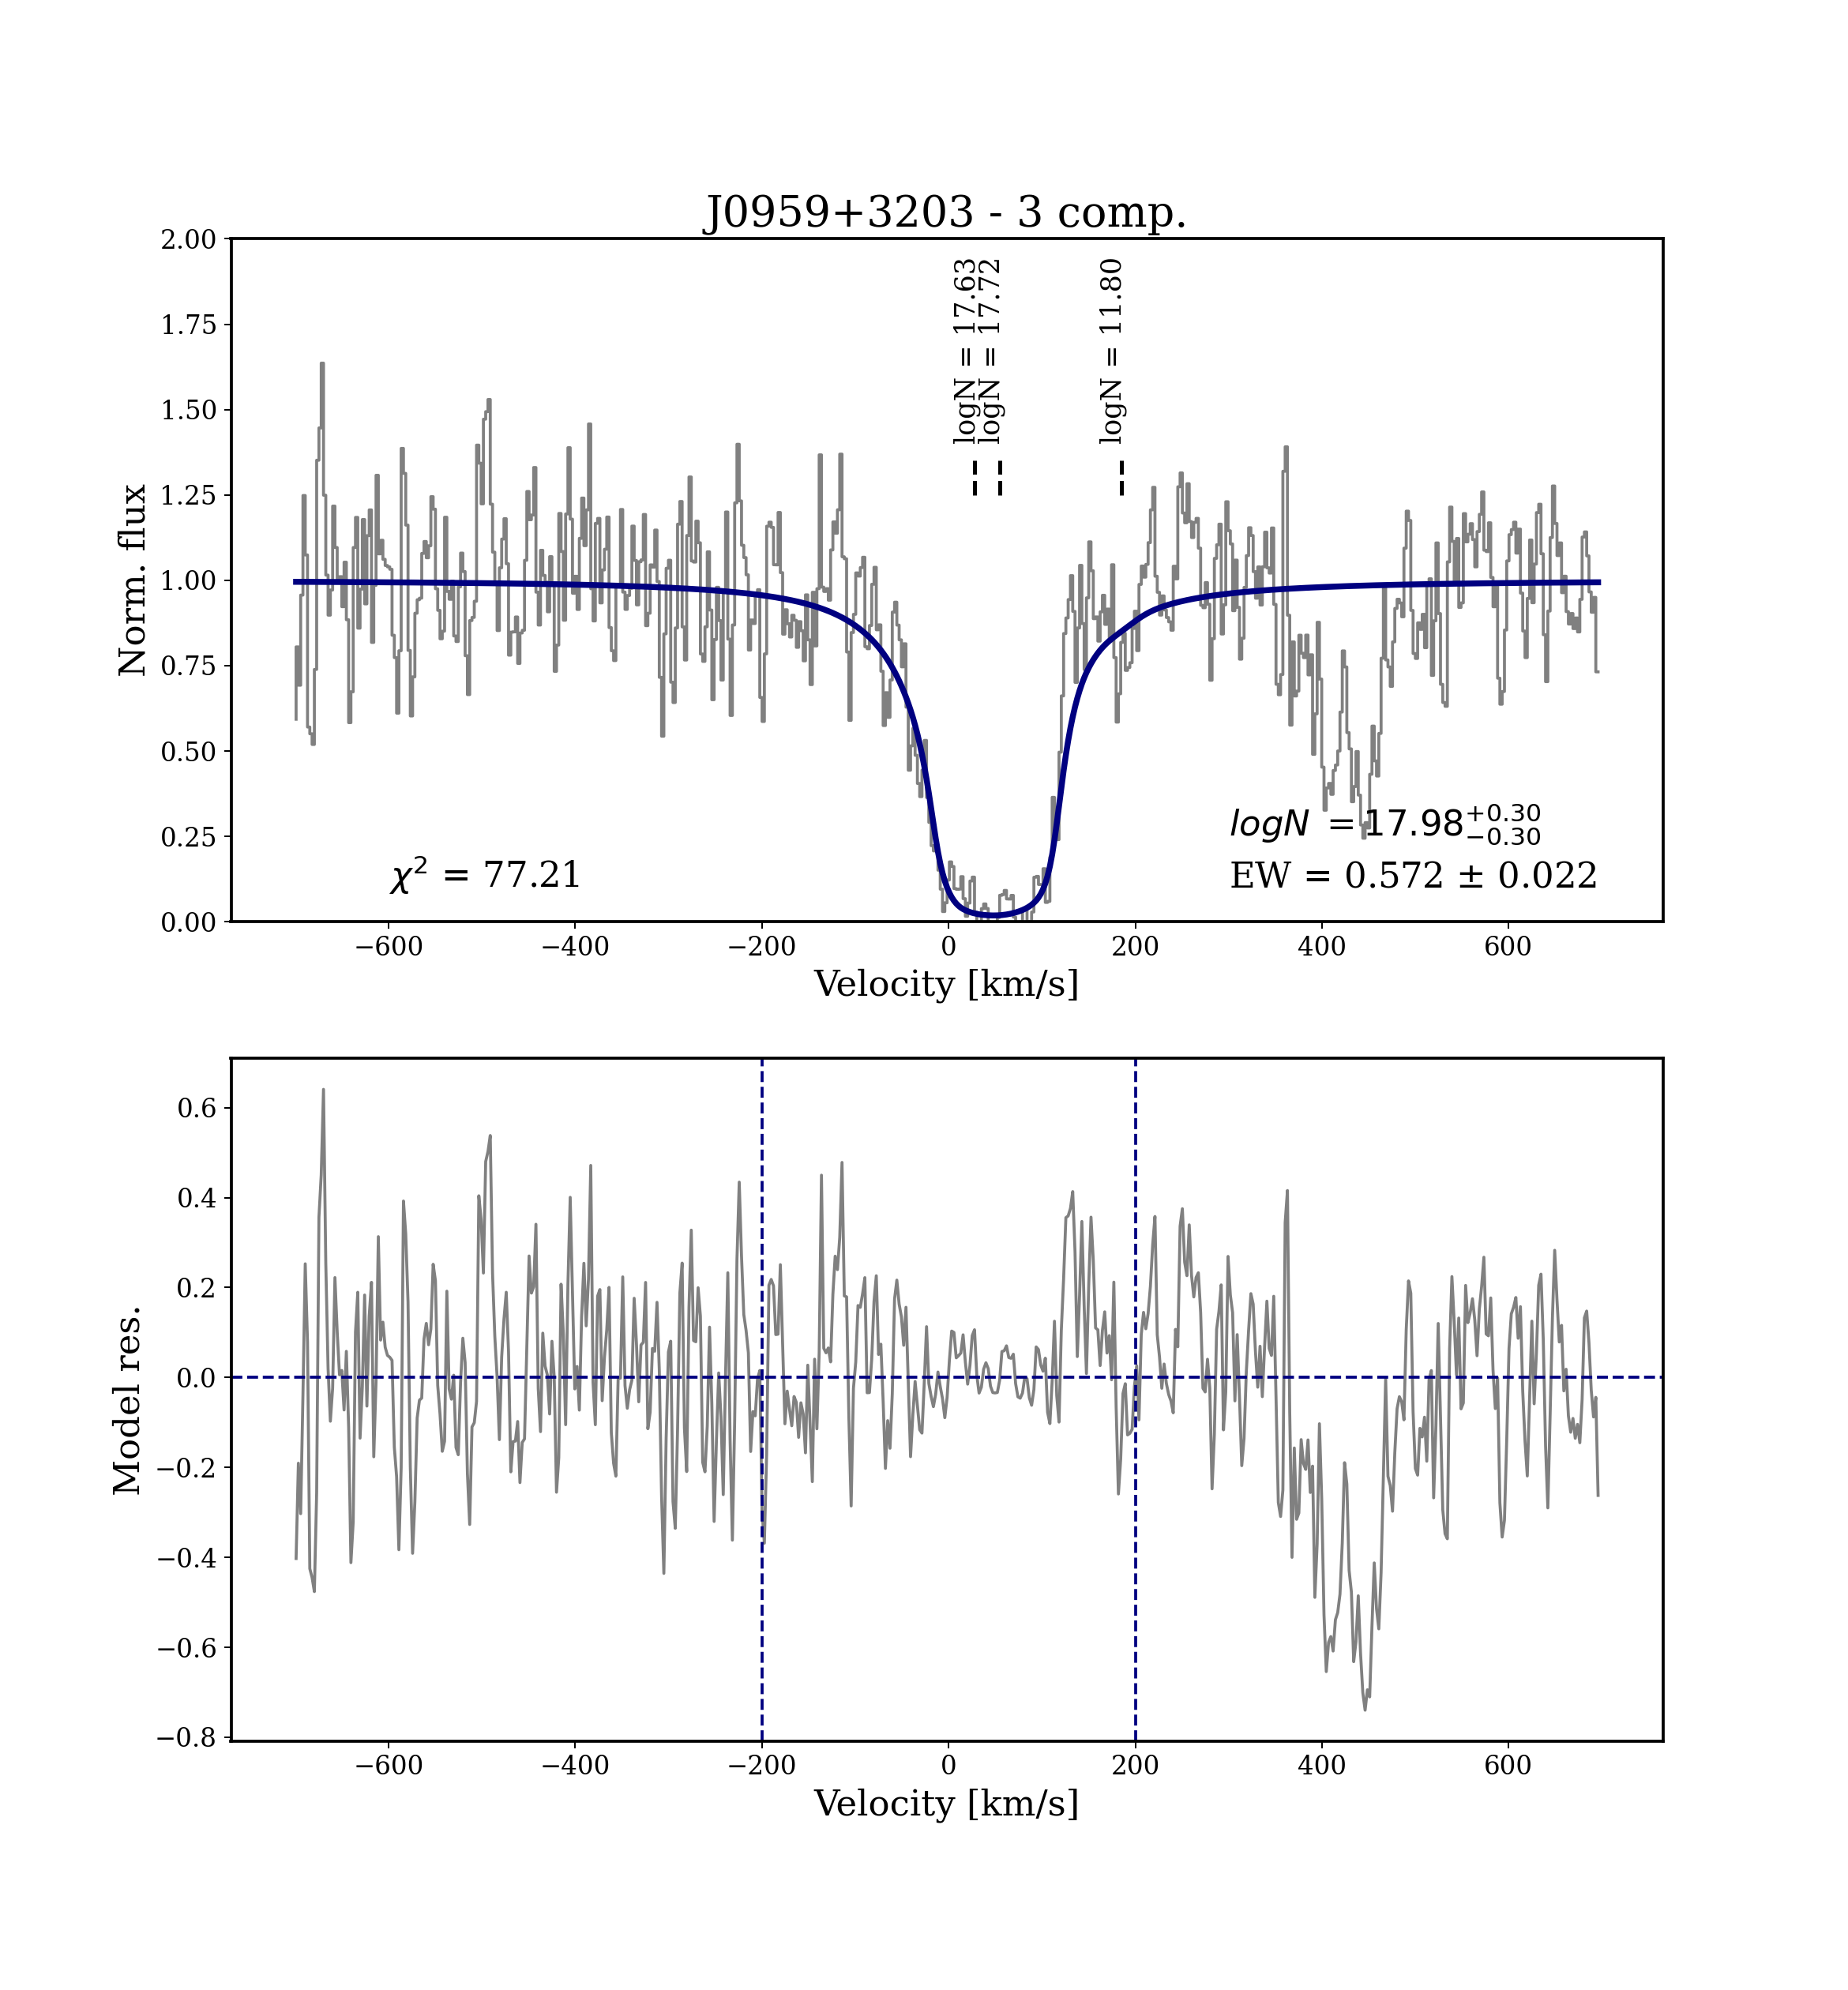

[14.44092914 15.8028888  11.14727323] [17.96900532 17.97103657 12.59156223]
9 571
0.18021199012034736


In [150]:

#clear paper-quality plot
fig = plt.figure(figsize=(13,14))

#plt.step(velo, error, c='r')
#plot the fit
theta_prime=t.best_theta
best_fit, f1 = s.model_fit(theta_prime, wave)
best_v = theta_prime[2 * nclump:3 * nclump]
value1, value2=t.low_theta,t.high_theta

best_N = theta_prime[0:nclump]
low_N = value1[0:nclump]
high_N = value2[0:nclump]  
print(low_N, high_N)

#perform Chi-Square Goodness of Fit Test
chi2=stats.chisquare(f_obs=best_fit, f_exp=fx_norm)[0]
## BIC
k = np.size(theta_prime) #numebr of free params
n = np.size(fx_norm)
res_sq_sum = np.sum((fx_norm-best_fit)**2)
print(k,n)
bic = n * np.log(res_sq_sum/n) + k * np.log(n)

plt.subplot(211)
plt.step(slice_vel,fx_smooth_norm, c='gray')
plt.plot(slice_vel, best_fit, lw=3, c='navy')
plt.title(tar_name +" - "+ str(nclump)+" comp.")
plt.xlabel("Velocity [km/s]")
plt.ylabel("Norm. flux")
Ntot=0
err_up, err_down=0,0
for iclump in range(0,nclump):
        err_up +=((high_N[iclump])-(best_N[iclump]))**2
        err_down +=((high_N[iclump])-(best_N[iclump]))**2
        
        plt.plot([best_v[iclump],best_v[iclump]],[1.25,1.35],'k--',lw=2)
        text1=r'logN = '+ np.str('%.2f' % theta_prime[iclump])# +'^{ + ' + np.str('%.2f' % (high_N[iclump]-best_N[iclump]))+'}'+ '_{ -' +  np.str('%.2f' % (best_N[iclump]-low_N[iclump]))+'}$'
        plt.text(theta_prime[-nclump + iclump],1.4,text1,fontsize=14,rotation=90, rotation_mode='anchor')
        #text2=r'$b ='+np.str('%.0f' % best_b[iclump]) +'^{ + ' + np.str('%.0f' % (high_b[iclump]-best_b[iclump]))+'}'+ '_{ -' +  np.str('%.0f' % (best_b[iclump]-low_b[iclump]))+'}$'
        Ntot+=10**theta_prime[iclump]
        #plt.text(best_v[iclump]+30,1.2, text2,fontsize=14,rotation=90, rotation_mode='anchor')
plt.ylim([0,2])
print((np.sqrt(err_down))/5.)

text=r'$logN \;= '+ np.str('%.2f' % np.log10(Ntot)) +'^{ + ' + np.str('%.2f' % (np.sqrt(err_up)/nclump))+'}'+ '_{ -' +  np.str('%.2f' % (np.sqrt(err_down)/nclump))+'}$'
plt.text(300, 0.25, text)     
plt.text(300, 0.1, "EW = "+np.str(round(eqw['ew_tot'],3)) + r" $\pm$ "+np.str(round(eqw['err_ew_tot'],3)))   
plt.text(-600, 0.1, r"$\chi^2$ = "+np.str(round(chi2,2)))         
#plt.text(-600, 0.25, "BIC = "+np.str(round(bic,2)))         


plt.subplot(212)
plt.plot(slice_vel, fx_smooth_norm-best_fit, c='gray')
plt.axhline(0.0, c='navy', ls='--')
plt.xlabel("Velocity [km/s]")
plt.ylabel("Model res.")
plt.axvline(-200, ls='--', c='navy')
plt.axvline(200, ls='--', c='navy')
fig.savefig(tar_name+"_HI_fit_"+str(nclump)+".pdf")




In [151]:
## BIC
k = np.size(theta_prime) #numebr of free params
n = np.size(fx_norm)
res_sq_sum = np.sum((fx_norm-best_fit)**2)
print(k,n, res_sq_sum/n)
bic = n * np.log(res_sq_sum/n) + k * np.log(n)
print(bic)
bic2 = (res_sq_sum + np.log(n)*k)
print(bic2)

9 571 0.08777168771746112
-1332.1258008147738
107.2441365735744


In [152]:

BIC = np.append(BIC, bic2)
print(BIC)

[  0.         107.24413657]


In [155]:
## save parameters

outfilename= tar_name


best_N=theta_prime[0:nclump]
best_b=theta_prime[nclump:2*nclump]
best_v=theta_prime[2*nclump:3*nclump]

low_N=theta_low[0:nclump]
low_b=theta_low[nclump:2*nclump]
low_v=theta_low[2*nclump:3*nclump]

high_N=theta_high[0:nclump]
high_b=theta_high[nclump:2*nclump]
high_v=theta_high[2*nclump:3*nclump]

out={}

out['best_N']=best_N
out['best_b']=best_b
out['best_v']=best_v
out['low_N']=low_N
out['low_b']=low_b
out['low_v']=low_v
out['high_N']=high_N
out['high_b']=high_b
out['high_v']=high_v


best_fit1,f11 = s.model_fit(theta_prime,wave)

#out['velo'] = slice_velo
out['best_fit']=best_fit1
out['best_ind_fit']=f11

# Now Finally save everything
with open(outfilename+"-"+str(nclump)+'_fit.p', 'wb') as handle:
    pickle.dump(out,handle, pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>


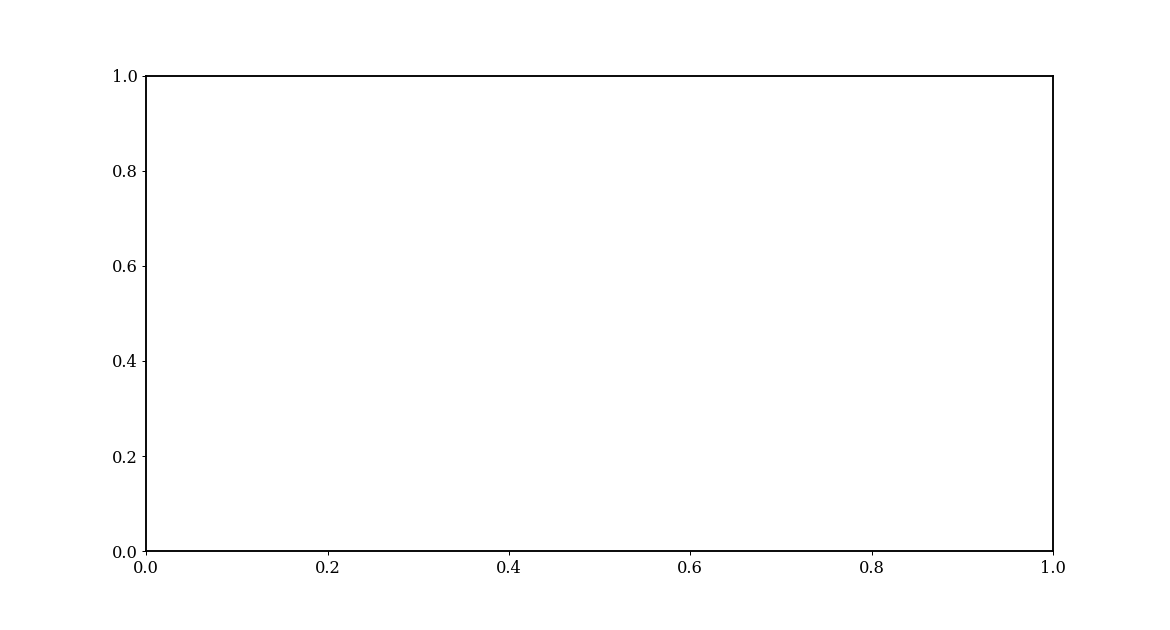

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

In [154]:
fig = plt.figure()
plt.plot(range(2,0, -1), BIC[1:], 'bo', ls='--')
plt.xlabel("number of components")
plt.ylabel("BIC")
fig.savefig(tar_name+"_BIC.png")